Show the daily PowerSpectralDensities over the course of a year

## Load Libraries

In [45]:
from obspy import * 
from pandas import *
from os import listdir

import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [46]:
host = os.uname()[1]
if host == "kilauea":
    homepath = "/import/kilauea-data/"
    out_figs = "/home/brotzer/Documents/ROMY/LowNoiseModel/figures/"
elif host == "lighthouse":
    homepath = "/home/andbro/kilauea-data/"
    out_figs = "/home/andbro/Documents/ROMY/LowNoiseModel/figures/"

In [47]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero, zeros
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

## Configurations

In [48]:
config = {}

config['datadir'] = f"{homepath}ROMY/RotationSpectra/data/"

config['outdir_figures'] = out_figs

config['station'] = "ROMY" ## ROMY | RLAS | ROMY_ADR
config['year'] = "2019"
config['interval'] = 3600
config['stats'] = "medians" ## minimals | medians


config['project'] = f"run_{config['year']}_{config['station']}-Z_{config['interval']}/"
config['datafile'] = f"{str(config['project']).strip('/')}_daily_{config['stats']}.pkl"

config['columns'] = f"{str(config['project']).strip('/')}_columns.pkl"
config['columns'] = f"{str(config['project']).strip('/')}_frequency_axis.pkl"

# config['limit'] = 1e-21 # 1e-17
if config['station'] == "RLAS":
    config['threshold'] = 1e-22
elif config['station'] == "ROMY":
    config['threshold'] = 1.5e-18
elif config['station'] == "ROMY_ADR":
    config['threshold'] = 1.5e-18

## Load Data

In [49]:
frequencies = read_pickle(config['datadir']+config['project']+config['columns'])

print(f" -> loading: {config['datadir']+config['project']+config['datafile']}")
df = read_pickle(config['datadir']+config['project']+config['datafile'])
df

 -> loading: /home/andbro/kilauea-data/ROMY/RotationSpectra/data/run_2019_ROMY-Z_3600/run_2019_ROMY-Z_3600_daily_medians.pkl


""


In [41]:
def __get_array_from_dataframe(df):
    
    from pandas import to_numeric
    
    ## convert to list
    psds = []
    for col in np.array(df.columns):
        
        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(np.array(df[col]))

    return np.array(psds)

In [42]:
psds = __get_array_from_dataframe(df)
columns = df.columns

Check threshold to reject bad psds

In [24]:
threshold = config['threshold']

dates_all, arr = [], []
count_rejected = 0

for date in date_range(f"{config['year']}0101", f"{config['year']}1231"):
    date_mod = str(date).split(" ")[0].replace("-","")
    dates_all.append(date_mod)
    
    if date_mod in df.columns: 
        if df[date_mod].mean() < threshold and df[date_mod].median() > 1e-30:
            arr.append(df[date_mod])
        else:
            count_rejected += 1
            arr.append(np.zeros(df.shape[0]))
    else:
        arr.append(np.zeros(df.shape[0]))
        
print(f"rejected spectra: {count_rejected}")

arr = np.array(arr)
dates_all = np.array(dates_all)

# psds = arr

rejected spectra: 0


In [37]:
def __makeplot_colorlines(config, ff, psds, columns):

    from numpy import isnan, median, mean, std, array, zeros, linspace
    from scipy.stats import median_abs_deviation as mad
    
    psds_median, psds_mean, psds_std, psds_mad = [],[],[],[]
    for fcross in range(psds.shape[1]):
        data = psds[:,fcross]
        ll = len(data[data[~isnan(data)]>0])
        psds_median.append(median(data[data[~isnan(data)]>0]))
#         psds_mean.append(mean(data[~isnan(data)]))
#         psds_std.append(std(data[~isnan(data)]))
#         psds_mad.append(mad(data[~isnan(data)]))
        
    psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)
    
        
    ff = 1/ff
        
    ##____________________________
    
    fig, ax = plt.subplots(1,1, figsize=(15,10), sharey=False, sharex=True)

    font = 14

    N = psds.shape[0]
    colors = plt.cm.rainbow(linspace(0, 1, N))


    for n, psd in enumerate(psds):
        ax.loglog(ff, psd, color=colors[n], alpha=0.7)


    ## add scatter for colorbar object only
    for n, psd in enumerate(psds):
        p2 = ax.scatter(ff[0], psd[0], s=0., c=n, cmap='rainbow', vmin=0, vmax=N)

    ax.loglog(ff, psds_median, 'black', zorder=3, alpha=0.9, label="median")
    ax.loglog(ff, psds_minimal, 'grey', zorder=3, alpha=1.0, label="minimal")
    
    ax.legend()
    
    ax.set_xlabel("Period (s)", fontsize=font)

    ax.set_ylabel(r"PSD (rad$^2$/s$^2$/$Hz)$", fontsize=font)
    
    ax.grid(True, which="both", ls="-", alpha=0.5)
    
    if config['station'] == "ROMY":
        ax.set_ylim(7e-23, 3e-18)
    elif config['station'] == "RLAS":
        ax.set_ylim(1e-28, 1e-21)

    ax.set_xlim(1, 200)
#     ax.set_xlim(min(ff), max(ff))
#     ax.set_xlim(10**log10(config['frequency_limits'][0]), 10**log10(config['frequency_limits'][1]))
    
    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='horizontal', ax=ax, aspect=50)

    ## redefine ticks of colorbar
#     new_ticks=[]
#     for n, t in enumerate(cbar.get_ticks()):
#         print(n)
#         new_ticks.append(columns[int(t)])
#     print(new_ticks)
#     cbar.ax.set_xticklabels(columns)

    ax.set_title(f"{config['station']}  {config['year']}  [{config['stats']},  {ll}]", fontsize=font-1)

    plt.show();
    
    out = DataFrame()
    out['frequencies'] = ff
    out['psds_minimal'] = array(psds_minimal)
    out['psds_median'] = array(psds_median)
#     out['psds_mean'] = array(psds_mean)
#     out['psds_std'] = array(psds_std)
#     out['psds_mad'] = array(psds_mad)
    
    return fig, out

ValueError: x and y must have same first dimension, but have shapes (12800,) and (1279,)

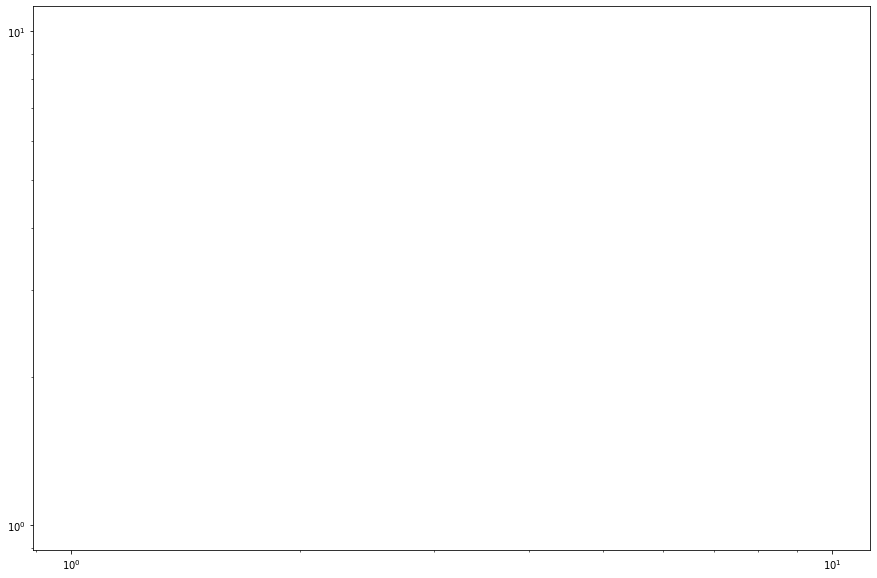

In [43]:
# fig, out = __makeplot_colorlines(config, frequencies, psds, columns)
fig, out = __makeplot_colorlines(config, frequencies, arr, columns)

In [28]:
# fig.savefig(config['outdir_figures']+config['station']+config['year']+config['stats']+"PSD_yearly_lines"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)

### Limit frequency range

In [32]:
frequencies = frequencies[3:2000]
arr = arr[:,3:2000]

In [36]:
frequencies.shape, psds.shape

((1994,), (3, 1279))

## Plots

ValueError: zero-size array to reduction operation minimum which has no identity

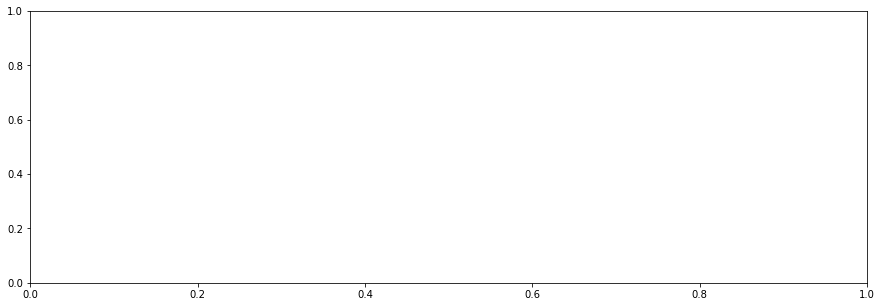

In [33]:
x_axis = range(arr.shape[0])
y_axis = frequencies

from matplotlib import colors

font = 12 

fig, ax  = plt.subplots(1,1, figsize=(15,5))

cmap = plt.cm.get_cmap('magma')
cmap.set_under(color='black')
cmap.set_over(color='white')

im = plt.pcolor(x_axis, y_axis, arr.T, 
                cmap=cmap,
                alpha=0.99,
#                 vmin=np.min(np.min(arr[np.nonzero(arr)])),
#                 vmax=np.max(np.max(arr)),
                vmin=np.min(np.min(arr[np.nonzero(arr)])),
                vmax=5e-18,
                norm=colors.LogNorm()
                )


ax.set_yscale("log")

ax.set_title(f"{config['station']} PSD of {config['year']} [{config['stats']}]", fontsize=font+1, pad=0.3)
ax.set_xlabel(f"Days of {config['year']}", fontsize=font)
ax.set_ylabel("Frequency (Hz)", fontsize=font)

# ax2 = ax.twinx()
# ax2.set_xlabel("Period (s)", fontsize=font, labelpad=5)
# ax2.set_xticklabels(1/frequencies, fontsize=11)    
# ax2.set_yscale("log"

ax.set_ylim(0.05, 1.0)

caxes = fig.add_axes()
cb = plt.colorbar(im, cax=caxes, alpha=1.0)
cb.set_label(r"Power Spectral Density ($\frac{rad^2}{s^2 Hz}$)", fontsize=font)

plt.show();

In [16]:
# fig.savefig(config['outdir_figures']+config['station']+config['year']+config['stats']+"PSD_yearly"+".png", fmt="png", bbox_inches="tight", dpi=300, transparent=None)